#### Imports

In [15]:
import os
if os.path.basename(os.getcwd()) != 'Learning-Dynamic-Systems':
    os.chdir(".\\..") 

from indirect_identification.sps_indirect import SPS_indirect_model, d_tfs
from indirect_identification.armax import ARMAX
from fusion.fusion import *
import numpy as np
import matplotlib.pyplot as plt
import os

np.random.seed(42)

### Fusion (via SPS indicators)

##### Define an ARX system, generate input/output data

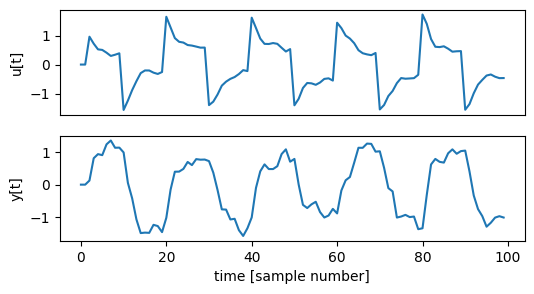

In [3]:
a = 0.8
b = 0.4
A = [1, -a]   # A(z^-1) = 1 - 0.33z^-1
B = [b]       # B(z^-1) = 0.22z^-1
C = [1, 0.15]    # C(z^-1) = 1 + 0.15z^-1
F = [0.31, 0.23] # F(z^-1) = 0.31 + 0.23z^-1
L = [1]          # L(z^-1) = 1

armax_model = ARMAX(A, B, C, F, L)
n_samples = 100
R = np.sign(np.sin(np.linspace(0, 10*np.pi, n_samples))) # square wave reference signal, works with both cupy and numpy
Y, U, N, R = armax_model.simulate(n_samples, R, noise_std=0.2)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6,3))
ax = ax.flatten()
ax[0].plot(U)
ax[0].set_xticks([])
ax[0].set_ylabel('u[t]')
ax[1].plot(Y)
ax[1].set_ylabel('y[t]')
ax[1].set_xlabel('time [sample number]')
plt.show()

##### Demonstrate fusion of two different confidence regions

In [4]:
F = ([0.31, 0.23], [1])
L = ([1], [1])
n_a = 1
n_b = 1
search_ranges = [[0.1, 1], [0.1, 1]]
search_res = [21, 21]

m = 100
q = 5
model = SPS_indirect_model(m, q)
conf_region1 = get_conf_region(search_ranges, search_res, model, n_a, n_b, C, L, F, Y, R)

m = 100
q = 50
model = SPS_indirect_model(m, q)
conf_region2 = get_conf_region(search_ranges, search_res, model, n_a, n_b, C, L, F, Y, R)

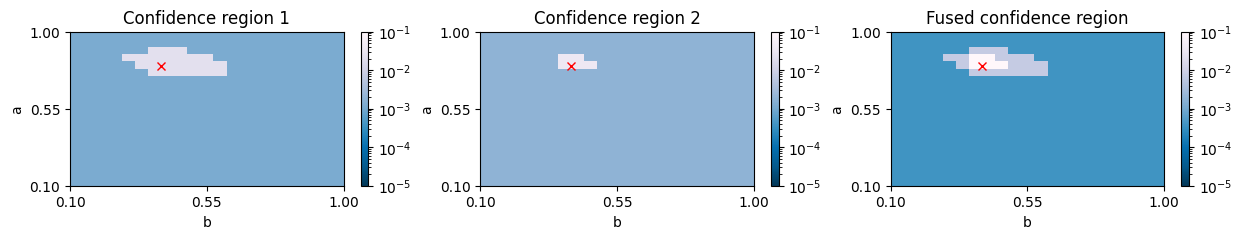

In [5]:
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(15,2))

a_range = np.linspace(search_ranges[0][0], search_ranges[0][1], search_res[0])
b_range = np.linspace(search_ranges[1][0], search_ranges[1][1], search_res[1])

# Plot the two separate SPS confidence regions
p_matrix1 = construct_p_tensor(conf_region1, [a_range, b_range], p=0.95)
p_matrix2 = construct_p_tensor(conf_region2, [a_range, b_range], p=0.95)
plot_fused_conf_region(p_matrix1, fig, axes[0], a_range, b_range, true_a=a, true_b=b)
plot_fused_conf_region(p_matrix2, fig, axes[1], a_range, b_range, true_a=a, true_b=b)
axes[0].set_title("Confidence region 1")
axes[1].set_title("Confidence region 2")

# Plot the fused SPS confidence region
fused = fuse(p_matrix2, p_matrix1, forget=0)
plot_fused_conf_region(fused, fig, axes[2], a_range, b_range, true_a=a, true_b=b)
axes[2].set_title("Fused confidence region")

plt.show()

##### Demonstrate sampling of a non-binary confidence region
- Black dots: the plants chosen from the non-binary confidence region.
    - These plants then represent those which are "inside" the confidence set - a yes/no answer, no longer a probability.
    - This concrete set of plants is required for the min-max optimisation problem.

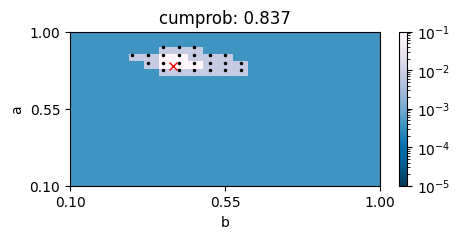

In [6]:
pt_in_set, p = sample_fused_conf_region(fused,[a_range, b_range],cumprob=0.8)
a_in_set = pt_in_set[:,0]
b_in_set = pt_in_set[:,1]
sampled_plants = np.array([b_in_set, a_in_set]).T

fig, ax = plt.subplots(figsize=(5,2))
plot_fused_conf_region(fused, fig, ax, a_range, b_range, true_a=a, true_b=b)
plot_fused_conf_region(fused, fig, ax, a_range, b_range, title=f"cumprob: {p:.3f}", colorbar=False)
plot_pts_in_conf_region(sampled_plants, x_dim=0, y_dim=1, fig=fig, ax=ax)

##### Show how a fused confidence region evolves over time

First, run the system for a few iterations, fusing the SPS confidence regions generated from each run.

In [7]:
k = 0.22

points_in_conf_region_vals = []
sampled_conf_region_vals = []
a_vals = []
p_vals = []
posterior_vals = []

n_iters = 16
param_change_iter = 4

for i in range(n_iters):

    # ~~~~~~~~~~~ change a system parameter halfway through, to see how the algorithm adapts to change

    if i >= param_change_iter:
        a = 0.6
    else:
        a = 0.3
    b = 0.22


    # ~~~~~~~~~~~ run the system, gather input/output data

    n_samples = 200

    A = [1, -a]
    B = [b]
    C = [1, 0.15]
    F = [k]
    L = [1]
    armax_model = ARMAX(A, B, C, F, L)

    R = np.sign(np.sin(np.linspace(0, 10*np.pi, n_samples))) # square wave
    Y, U, N, R = armax_model.simulate(n_samples, R, noise_std=0.2)

    # ~~~~~~~~~~~ identify SPS confidence region using indirect SPS

    m = 20
    q = 1
    model = SPS_indirect_model(m, q, n_samples-1)
    
    F = ([k], [1])
    L = ([1], [1])
    conf_region_pts = get_conf_region(search_ranges, search_res, model, n_a, n_b, C, L, F, Y, R)
    a_in_set = conf_region_pts[:,0]
    b_in_set = conf_region_pts[:,1]

    # ~~~~~~~~~~~ fuse this run's SPS confidence region with previous ones

    if i == 0:
        # posterior = construct_p_matrix(conf_region_pts, a_range, b_range, p=1-q/m)
        posterior = construct_p_tensor(conf_region_pts, [a_range, b_range], p=1-q/m)
    else:
        # posterior from last iteration is this iteration's prior
        prior = posterior

        # fuse the new info with the prior
        new_info = construct_p_tensor(conf_region_pts, [a_range, b_range], p=1-q/m)
        posterior = fuse(new_info, prior, forget=0)


    # ~~~~~~~~~~~ store results
    
    pt_in_set, p = sample_fused_conf_region(posterior,[a_range, b_range],cumprob=1-q/m)
    a_in_set = pt_in_set[:,0]
    b_in_set = pt_in_set[:,1]

    a_vals.append(a)
    p_vals.append(p)
    points_in_conf_region_vals.append(conf_region_pts)
    posterior_vals.append(posterior)
    sampled_conf_region_vals.append(np.array([b_in_set, a_in_set]).T)

Then plot how it evolves over time.

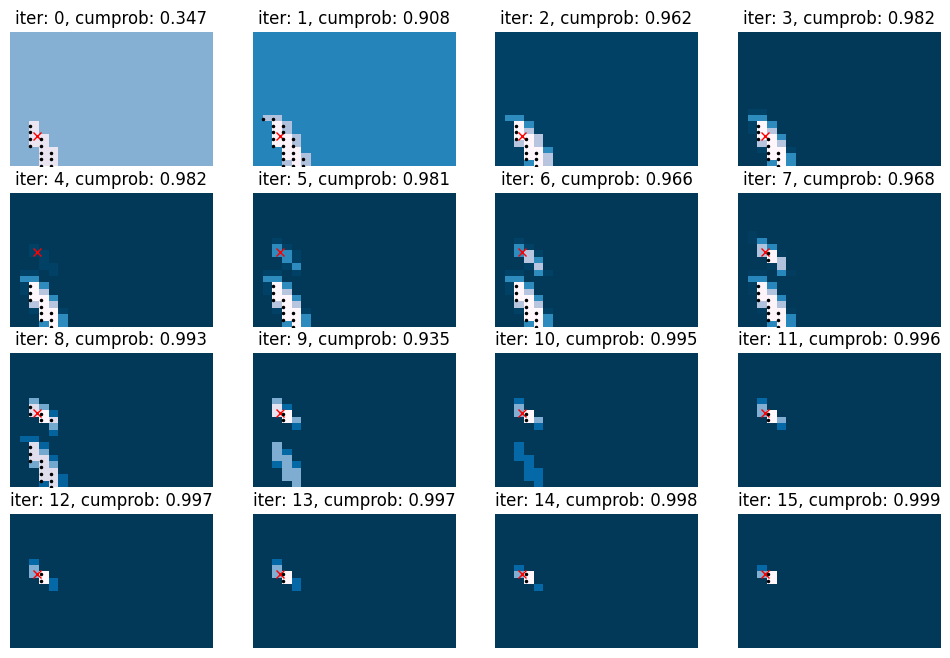

In [8]:
# Set up the grid of plots
n_plots = 16
n_cols = 4
n_rows = int(np.ceil(n_plots / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 2))
axes = axes.flatten()

# Plot the fused confidence region from each SPS run, as well as the points sampled from it
for idx in range(n_plots):

    plot_fused_conf_region(posterior_vals[idx], fig, axes[idx], a_range, b_range, title=f"iter: {idx}, cumprob: {p_vals[idx]:.3f}", colorbar=False)
    axes[idx].plot(b, a_vals[idx], 'rx')
    axes[idx].set_axis_off()

    # Optionally, also display which plants would be sampled from these non-binary confidence regions
    plot_pts_in_conf_region(sampled_conf_region_vals[idx], x_dim=0, y_dim=1, fig=fig, ax=axes[idx])
plt.show()

#### Demonstrate fusing and sampling confidence region for an nth order system

Generate input/output data, find SPS confidence region twice

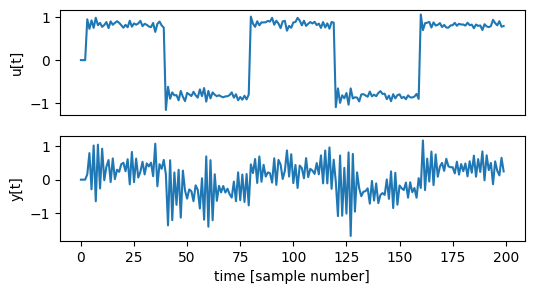

In [9]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ define system and generate data

a1 = -0.9
a2 = -0.1
b1 = 0.8

A  = [1, -a1, -a2]
B = [b1]
C = [1, 0.2, 0.04]
F = [0.3, 0.2] 
L = [1]
armax_model = ARMAX(A, B, C, F, L)

n_samples = 200
R = np.sign(np.sin(np.linspace(0, 5*np.pi, n_samples))) # square wave reference signal, works with both cupy and numpy
Y, U, N, R = armax_model.simulate(n_samples, R, noise_std=0.2)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6,3))
ax = ax.flatten()
ax[0].plot(U)
ax[0].set_xticks([])
ax[0].set_ylabel('u[t]')
ax[1].plot(Y)
ax[1].set_ylabel('y[t]')
ax[1].set_xlabel('time [sample number]')
plt.show()

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ get confidence region

B = [0] + B
G = (B, A)
H = (C, A)

F = (F, [1])
L = (L, [1])

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ get confidence region

n_a = 2
n_b = 1
search_ranges = [[-2, 2], [-2, 2], [0.1, 1]]
search_res = [41,41,10]

m = 20
q = 1
model = SPS_indirect_model(m, q)
conf_region1 = get_conf_region(search_ranges, search_res, model, n_a, n_b, C, L, F, Y, R)

m = 20
q = 1
model = SPS_indirect_model(m, q)
conf_region2 = get_conf_region(search_ranges, search_res, model, n_a, n_b, C, L, F, Y, R)

Contruct the fused confidence region

In [10]:
grid_axes = [np.linspace(search_ranges[i][0], search_ranges[i][1], search_res[i]) for i in range(len(search_ranges))]
pt1 = construct_p_tensor(conf_region1, grid_axes, p=0.95)
pt2 = construct_p_tensor(conf_region2, grid_axes, p=0.95)
pt = fuse(pt2, pt1, forget=0)
conf_region3, cumprob = sample_fused_conf_region(pt, grid_axes)

Compare the two binary confidence regions and the fused region

In [11]:
x_lb = np.min([np.min(conf_region1[:,0]), np.min(conf_region2[:,0]), np.min(conf_region3[:,0])])
x_ub = np.max([np.max(conf_region1[:,0]), np.max(conf_region2[:,0]), np.max(conf_region3[:,0])])
y_lb = np.min([np.min(conf_region1[:,1]), np.min(conf_region2[:,1]), np.min(conf_region3[:,1])])
y_ub = np.max([np.max(conf_region1[:,1]), np.max(conf_region2[:,1]), np.max(conf_region3[:,1])])
z_lb = np.min([np.min(conf_region1[:,2]), np.min(conf_region2[:,2]), np.min(conf_region3[:,2])])
z_ub = np.max([np.max(conf_region1[:,2]), np.max(conf_region2[:,2]), np.max(conf_region3[:,2])])

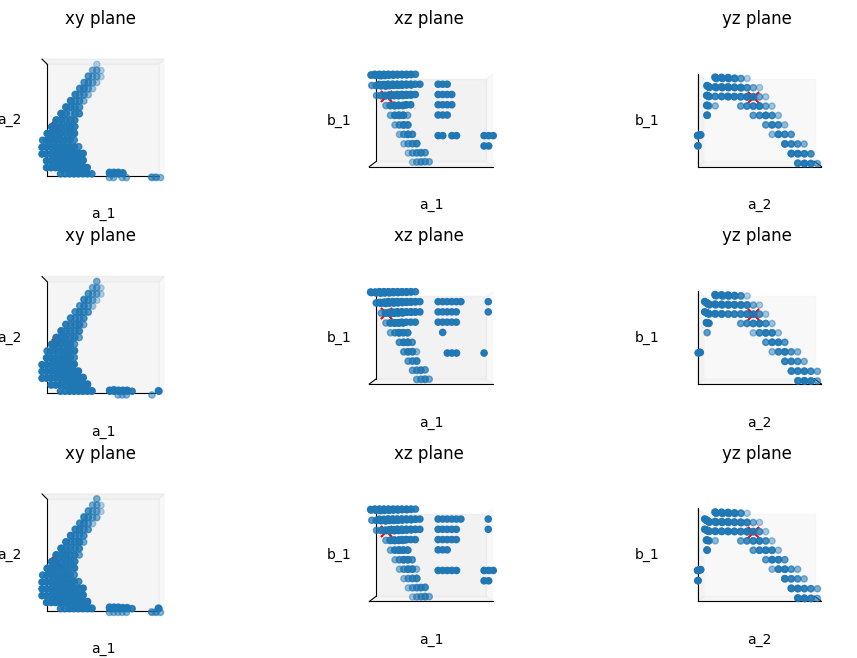

In [12]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ plot the two confidence regions and their fusion

fig = plt.figure(figsize=(12,8))

for i in range(3):
    ax = fig.add_subplot(3,3,i+1, projection='3d')
    scatter3d(conf_region1, ax, i)
    ax.scatter(a1, a2, b1, c='r', marker='x', s=64)

for i in range(3):
    ax = fig.add_subplot(3,3,i+4, projection='3d')
    scatter3d(conf_region2, ax, i)
    ax.scatter(a1, a2, b1, c='r', marker='x', s=64)

for i in range(3):
    ax = fig.add_subplot(3,3,i+7, projection='3d')
    scatter3d(conf_region3, ax, i)
    ax.scatter(a1, a2, b1, c='r', marker='x', s=64)

for i in range(9):
    fig.axes[i].set_xlim([x_lb, x_ub])
    fig.axes[i].set_ylim([y_lb, y_ub])
    fig.axes[i].set_zlim([z_lb, z_ub])

plt.show(block=True)
plt.switch_backend('inline')

##### Show how a fused confidence region evolves over time

First, run the system for a few iterations, fusing the SPS confidence regions generated from each run. \
Then, show how the confidence map evolves over time.

In [13]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ define system and generate data

a1 = -0.9
a2 = -0.1
b1 = 0.8

A  = [1, -a1, -a2]
B = [b1]
C = [1, 0.2, 0.04]
F = [0.3, 0.2] 
L = [1]
armax_model = ARMAX(A, B, C, F, L)

n_samples = 200
R = np.sign(np.sin(np.linspace(0, 5*np.pi, n_samples))) # square wave reference signal, works with both cupy and numpy

B = [0] + B
G = (B, A)
H = (C, A)
F = (F, [1])
L = (L, [1])

n_a = 2
n_b = 1
search_ranges = [[-2, 2], [-2, 2], [0.1, 1]]
search_res = [41,41,10]
m = 20
q = 1
model = SPS_indirect_model(m, q)

points_in_conf_region_vals = []
sampled_conf_region_vals = []
a_vals = []
p_vals = []
posterior_vals = []

n_iters = 8

for i in range(n_iters):

    
    # ~~~~~~~~~~~ run the system, gather input/output data

    n_samples = 200
    Y, U, N, R = armax_model.simulate(n_samples, R, noise_std=0.2)

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ get confidence region
    conf_region_pts = get_conf_region(search_ranges, search_res, model, n_a, n_b, C, L, F, Y, R)

    # ~~~~~~~~~~~ fuse this run's SPS confidence region with previous ones

    if i == 0:
        # posterior = construct_p_matrix(conf_region_pts, a_range, b_range, p=1-q/m)
        posterior = construct_p_tensor(conf_region_pts, grid_axes, p=1-q/m)
    else:
        # posterior from last iteration is this iteration's prior
        prior = posterior

        # fuse the new info with the prior
        # new_info = construct_p_matrix(conf_region_pts, a_range, b_range, p=1-q/m)
        new_info = construct_p_tensor(conf_region_pts, grid_axes, p=1-q/m)
        posterior = fuse(new_info, prior, forget=0)

    # ~~~~~~~~~~~ store results
    
    # a_in_set, b_in_set, p = sample_fused_conf_region(posterior,a_range,b_range,cumprob=1-q/m)
    pt_in_set, p = sample_fused_conf_region(posterior, grid_axes, cumprob=1-q/m)

    a_vals.append(a)
    p_vals.append(p)
    points_in_conf_region_vals.append(conf_region_pts)
    posterior_vals.append(posterior)
    sampled_conf_region_vals.append(pt_in_set)

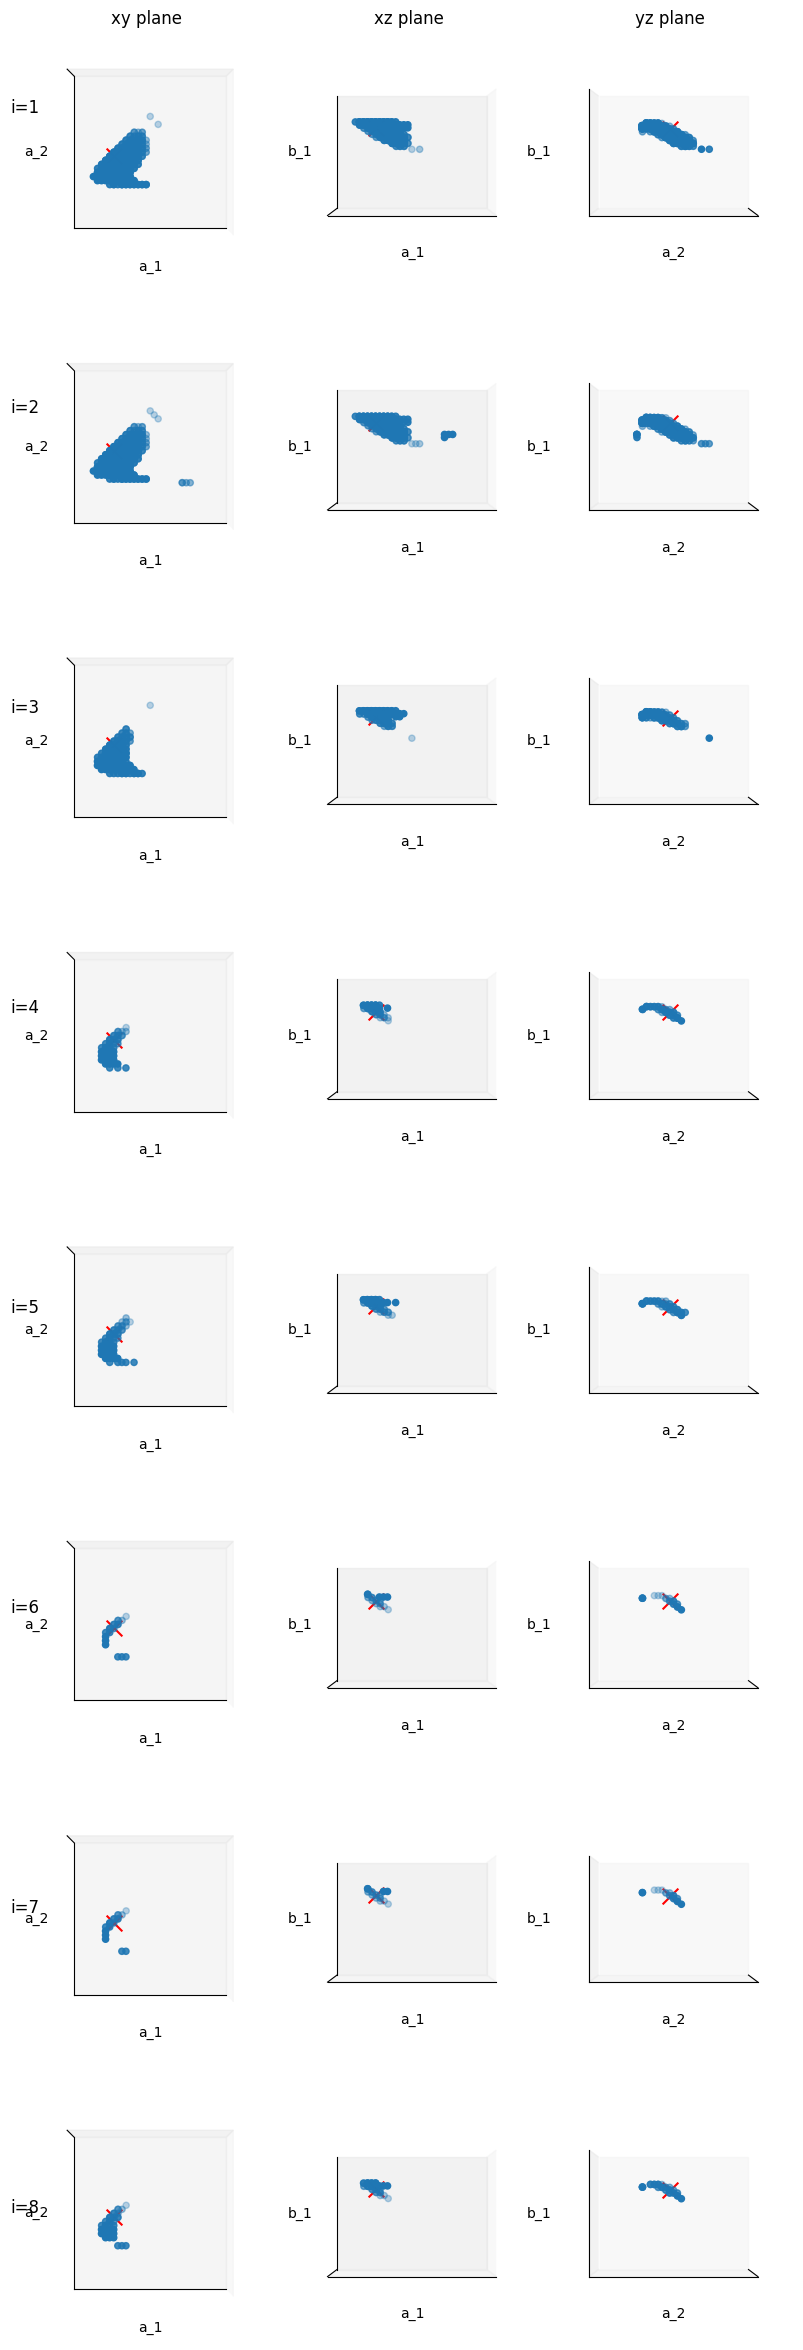

In [14]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ plot the two confidence regions and their fusion

x_lb = -2
x_ub = 2
y_lb = -2
y_ub = 2
z_lb = -2
z_ub = 2

fig, axes = plt.subplots(n_iters, 3, subplot_kw={'projection': '3d'}, figsize=(8,n_iters*3))
# ax = fig.add_subplot(n_iters,3,3*i+j+1, projection='3d')

for i in range(n_iters):
    for j in range(3):
        pts, cumprob = sample_fused_conf_region(posterior_vals[i], grid_axes)
        scatter3d(pts, axes[i][j], j)
        axes[i][j].scatter(a1, a2, b1, c='r', marker='x', s=128)

for i in range(n_iters*3):
    fig.axes[i].set_xlim([x_lb, x_ub])
    fig.axes[i].set_ylim([y_lb, y_ub])
    fig.axes[i].set_zlim([z_lb, z_ub])
    if i >= 3:
        fig.axes[i].set_title(None)
for i in range(n_iters):
    fig.text(0.02, 1 - i * (1/n_iters) - 0.05, f"i={i+1}", ha='center', va='top', fontsize=12)

plt.tight_layout()
plt.show(block=True)
plt.switch_backend('inline')